In [1]:
# Leave lines below uncommented this if you get:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from losses import bce_weighted_dice_loss
from scipy.stats import iqr

In [2]:
from glomerulus import Glomerulus, Patch, KidneySampleDataset, get_glomeruli, generate_glomerulus_patches
from networks import CBAM_R2UNet_v2
from utils import read_tiff, dataset_label_mean
from losses import dice_loss

In [3]:
TEST_IMAGE_PATH = './kidney_dataset/train/aaa6a05cc.tiff'
TEST_LABEL_PATH = './kidney_dataset/train/aaa6a05cc.json'

test_image = read_tiff(TEST_IMAGE_PATH)

C:\Users\iraha\anaconda3\lib\site-packages\rasterio\__init__.py:320: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
import json
from matplotlib.patches import Polygon
import shapely

image_names = [
    'afa5e8098',
    '4ef6695ce',
    'c68fe75ea',
    '26dc41664',
    '095bf7a1f',
    '54f2eec69',
    '1e2425f28',
    'e79de561c',
    'cb2d976f4',
    'b9a3865fc',
    '8242609fa',
    '0486052bb',
    '2f6ecfcdf',
    'b2dc8411c',
    'aaa6a05cc'
]

root_dir = './kidney_dataset/train'

glomeruli_sizes = []

# Load label path from json file
for image_name in image_names:
    kidney_label = json.load(open(os.path.join(root_dir, image_name + '.json')))
    for element in kidney_label:
        if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
            label = element['geometry']
            if label['type'] == 'Polygon':
                coordinates = label['coordinates'][0]

#                 Create polygon from label coordinates and plot
                label_polygon = Polygon(coordinates, closed=True, color='red', alpha=0.2)

                glomeruli_sizes.append(shapely.geometry.Polygon(coordinates).area)

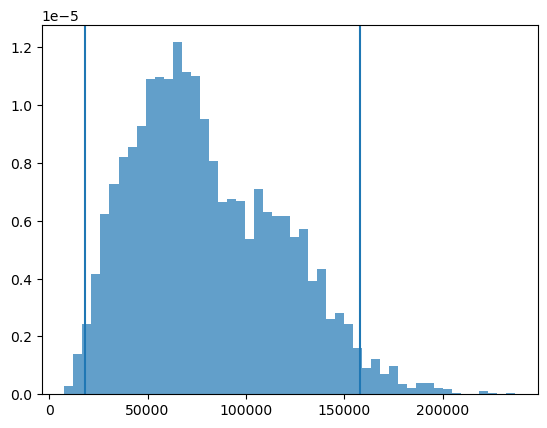

In [5]:
# Calculate median and iqr
median = np.median(glomeruli_sizes)
iqr_value = iqr(glomeruli_sizes)

# Calculate lower and upper bound to determine acceptable glomerulus sizes
lower_bound = median - 1 * iqr_value
upper_bound = median + 1.5 * iqr_value

plt.axvline(x=lower_bound)
plt.axvline(x=upper_bound)
_, _, _ = plt.hist(glomeruli_sizes, bins=50, density=True, alpha=0.7)


In [6]:
def test(model,test_image,test_glomeruli,image_value_lb = 100,image_value_ub = 205):
    out_img = np.zeros((
        int(np.ceil(test_image.shape[1] / 512) * 512),
        int(np.ceil(test_image.shape[2] / 512) * 512)
    ))
    intersection = 0
    union = 0
    smooth = 0.00000001
    for idx_y in tqdm(range(0, test_image.shape[1], 512)):
        for idx_x in range(0, test_image.shape[2], 512):
            center_x = idx_x + 512 // 2
            center_y = idx_y + 512 // 2
            test_patch = Patch(
                center_x = center_x,
                center_y = center_y,
                theta = 0,
                patch_size = 512,
                glomeruli = test_glomeruli,
                image = test_image
            )
            image = test_patch.render_image()
            label = test_patch.render_mask()
            mean = np.mean(image[0])
            if mean >image_value_ub or mean <image_value_lb:
                continue
            out = model.forward(torch.unsqueeze(torch.tensor(image), 0).type(torch.cuda.FloatTensor))
            out_array = out.cpu().detach().numpy()[0][0]
            intersection += np.sum(out_array * label[0])
            union += np.sum(out_array) + np.sum(label[0])
            out_img[idx_y: idx_y+512, idx_x: idx_x+512] = out_array

    diceLoss = 1 - (2 * intersection + smooth) / (union + smooth)
    print("Dice_loss = ",diceLoss )
    return out_img , diceLoss

  0%|          | 0/37 [00:00<?, ?it/s]

Dice_loss =  0.7464402780151423


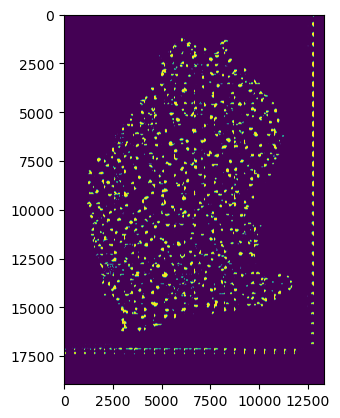

In [7]:
glo = 0.1
model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
remain = 1-glo
model.load_state_dict(torch.load(f'./dataset_ratio_models/CBAM_R2UNet_v2_train_{glo:.1f}_{remain:.1f}.npy_Weighted_BCE_Dice_t1000_b100_best_loss.npz'))
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
out_img , diceLoss = test(model,test_image,test_glomeruli)
plt.imshow(out_img)

In [8]:
flatten_out = out_img.flatten()

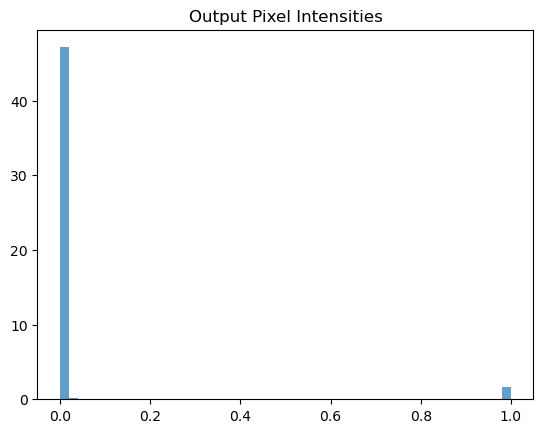

In [9]:
pixel_sample = np.random.choice(flatten_out, 30000)
plt.title('Output Pixel Intensities')
_, _, _ = plt.hist(pixel_sample, bins=50, density=True, alpha=0.7)

In [10]:
from scipy.ndimage import label, measurements
# Find connected components and calculate centroids
out_img_binary = np.where(out_img > 0.5, 1, 0)
labels, num_components = label(out_img_binary)
centroids = measurements.center_of_mass(out_img_binary, labels, range(1, num_components + 1))

# Calculate the sizes of each component
sizes = np.bincount(labels.ravel())[1:]

# Print the centroids and sizes
for i, centroid in enumerate(centroids):
    print("Connected Component", i+1, "Centroid:", centroid, "Size:", sizes[i])

C:\Users\iraha\AppData\Local\Temp\ipykernel_51308\2343564364.py:5: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  centroids = measurements.center_of_mass(out_img_binary, labels, range(1, num_components + 1))


Connected Component 1 Centroid: (58.901234567901234, 12759.586419753086) Size: 10368
Connected Component 2 Centroid: (522.9678316123908, 12755.561953931692) Size: 20144
Connected Component 3 Centroid: (1040.0611745513866, 12756.75938009788) Size: 19616
Connected Component 4 Centroid: (1321.8326732673268, 6030.69603960396) Size: 16160
Connected Component 5 Centroid: (1326.9583333333333, 6154.541666666667) Size: 1536
Connected Component 6 Centroid: (1439.7826267664173, 8180.918121363258) Size: 38496
Connected Component 7 Centroid: (1554.6074157303372, 6376.261348314607) Size: 35600
Connected Component 8 Centroid: (1548.545751633987, 12756.683006535948) Size: 19584
Connected Component 9 Centroid: (1668.2128560431102, 5657.044264819092) Size: 20784
Connected Component 10 Centroid: (1660.9994152046784, 6715.071929824561) Size: 13680
Connected Component 11 Centroid: (1745.2972350230414, 8157.039170506912) Size: 6944
Connected Component 12 Centroid: (1811.5710059171597, 7223.555226824457) Siz

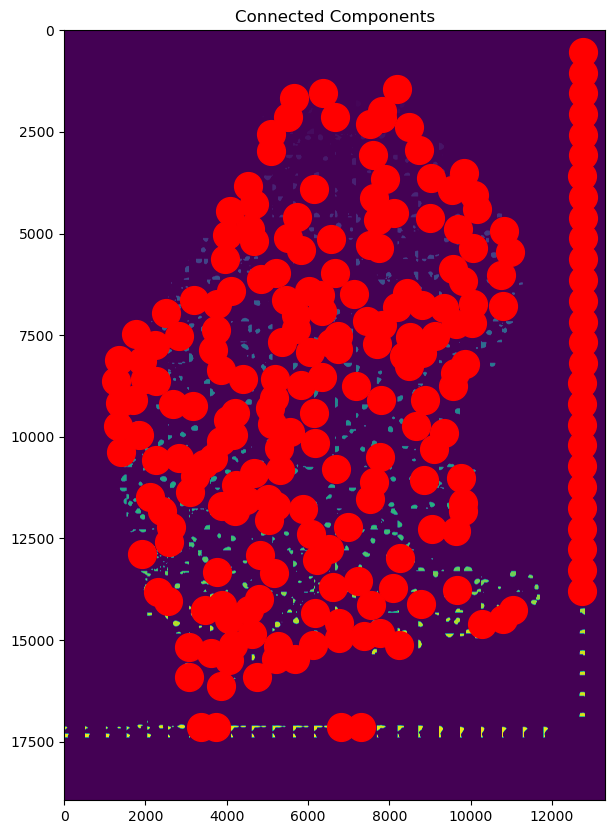

In [20]:
plt.figure(figsize=(10, 10))
plt.title('Connected Components')
plt.imshow(labels)

for idx, centroid in enumerate(centroids):
    if sizes[idx] > lower_bound and sizes[idx] < upper_bound:
        plt.plot([centroid[1]], [centroid[0]], marker='o', color='red', markersize=20)
plt.show()

C:\Users\iraha\AppData\Local\Temp\ipykernel_49556\4250620840.py:3: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  centroids = measurements.center_of_mass(out_img, labels, range(1, num_components + 1))


Component 1 Centroid: (7948.6062494339385, 12749.554624590275) Size: 8650752
Component 2 Centroid: (9191.563333144526, 6177.212731520462) Size: 116654080
Component 3 Centroid: (17209.583058302538, 5800.705814494838) Size: 6291456


In [68]:
sizes

array([10368, 20144, 19616, 16160,  1536, 38496, 35600, 19584, 20784,
       13680,  6944, 16224,  4896, 11472,  7584, 51536, 18416,   304,
        7472,  7776, 21328,   192, 19600, 23040,   592, 30096, 28272,
       25008, 17984,  1712, 23872,  2880,   384, 17232, 13680,  1168,
         160,   336,  3248,   240, 14768, 15952, 13680,  1680,  5680,
       16576,  5040,   400, 61760, 31552,   112, 14528, 24736, 27840,
        1552,   992,  1280, 11616, 12848, 11856,  9728,   128, 11248,
       15696, 10656,  9088, 27088,  1536,  1296,  5472, 27168,  6112,
        9792, 13536,  8928,  3072, 35168,  2736,   432,   224,    16,
          48, 16000, 24208, 13856, 19824,  9984, 45664, 11552, 23024,
        5968, 27456, 20000, 31184, 15168,  3344,  1664,  9568,   464,
       13120, 23728,    64, 14704,  9152,  6064,  5152, 22736,    96,
        3920, 22432,   592,  9136, 18752, 27872, 30896, 12848,  8960,
        1008, 28800, 10608,  6784, 17376, 13184,  9520, 10048,  1968,
        5328, 34736,